# Rental Bike Usage Prediction

Kaggle username: abc2022

Name: Abiramy S

### Imports

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import time
from scipy import stats

### Reading data

In [2]:
raw_train = pd.read_pickle('train.pkl')
raw_test = pd.read_pickle('test.pkl')

### Data exploration and visualisation

In [3]:
raw_train.head() #look at the top rows of train set

,Season,Year,Month,Hour,Holiday,Weekday,Working day,Weather situation,Temperature (normalized),Feels-like temperature (normalized),Humidity (normalized),Windspeed,Rental bikes count
0,Summer,1,6,18,0,1,1,Clear or partly cloudy,0.76,0.6667,0.27,0.4478,791
1,Fall,1,10,11,0,3,1,Misty and/or cloudy,0.36,0.3485,0.66,0.2239,189
2,Spring,0,6,22,0,6,0,Clear or partly cloudy,0.64,0.6212,0.57,0.2239,190
3,Spring,0,3,21,0,2,1,Misty and/or cloudy,0.42,0.4242,0.54,0.2836,87
4,Fall,1,11,5,0,2,1,Misty and/or cloudy,0.34,0.3333,0.66,0.1343,34


In [4]:
raw_test.head() #look at the top rows of test set

,Season,Year,Month,Hour,Holiday,Weekday,Working day,Weather situation,Temperature (normalized),Feels-like temperature (normalized),Humidity (normalized),Windspeed
0,Spring,1,6,19,0,5,1,Clear or partly cloudy,0.70,0.6364,0.42,0.1642
1,Summer,1,9,3,0,4,1,Clear or partly cloudy,0.44,0.4394,0.77,0.0000
2,Spring,0,4,14,0,1,1,Misty and/or cloudy,0.58,0.5455,0.49,0.1940
3,Spring,0,5,18,0,3,1,Clear or partly cloudy,0.72,0.6667,0.58,0.2239
4,Spring,0,4,3,0,3,1,Light snow or light rain,0.40,0.4091,0.94,0.3284


In [5]:
# Get info about the data
print('Train set shape:', raw_train.shape )
print('Test set shape:', raw_test.shape )

Train set shape: (12165, 13)
Test set shape: (5214, 12)


In [6]:
# desc.stat of train set before imputing the missing values
raw_train.describe()

,Rental bikes count
count,12165.000000
mean,189.081381
std,181.511771
min,1.000000
25%,39.000000
50%,141.000000
75%,280.000000
max,976.000000


Shows only one column, the others are left out because the missing values are coded as string objects.

In [7]:
# desc.stat of test set
raw_test.describe()

,Year,Month,Hour,Holiday,Weekday,Working day,Temperature (normalized),Feels-like temperature (normalized),Humidity (normalized),Windspeed
count,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000
mean,0.498274,6.486575,11.659954,0.027234,2.977177,0.681051,0.497706,0.475893,0.627535,0.189631
std,0.500045,3.420427,6.961792,0.162781,2.010727,0.466114,0.191468,0.170740,0.194066,0.122135
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,0.340000,0.333300,0.480000,0.104500
50%,0.000000,7.000000,12.000000,0.000000,3.000000,1.000000,0.500000,0.484800,0.630000,0.194000
75%,1.000000,9.000000,18.000000,0.000000,5.000000,1.000000,0.660000,0.621200,0.790000,0.253700
max,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,0.960000,1.000000,1.000000,0.850700


In [8]:
#check for missing values, by indicating how the missing values are coded in the data set
raw_train.isin(['missing']).sum(axis=0)

Season                                 39
Year                                   37
Month                                  31
Hour                                   50
Holiday                                30
Weekday                                36
Working day                            34
Weather situation                      27
Temperature (normalized)               36
Feels-like temperature (normalized)    24
Humidity (normalized)                  30
Windspeed                              34
Rental bikes count                      0
dtype: int64

In [9]:
# Compare the datatype of each column in the train and test sets
raw_test.info()
print('\n')
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5214 entries, 0 to 5213
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Season                               5214 non-null   object 
 1   Year                                 5214 non-null   int64  
 2   Month                                5214 non-null   int64  
 3   Hour                                 5214 non-null   int64  
 4   Holiday                              5214 non-null   int64  
 5   Weekday                              5214 non-null   int64  
 6   Working day                          5214 non-null   int64  
 7   Weather situation                    5214 non-null   object 
 8   Temperature (normalized)             5214 non-null   float64
 9   Feels-like temperature (normalized)  5214 non-null   float64
 10  Humidity (normalized)                5214 non-null   float64
 11  Windspeed                     

<AxesSubplot:xlabel='Rental bikes count', ylabel='Count'>

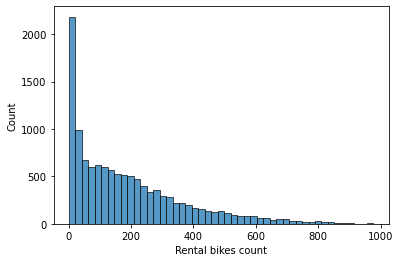

In [10]:
# look at the distribution of the target values
sns.histplot(raw_train['Rental bikes count'])

### Data cleaning

In [11]:
# replace missing values = 'missing' with np.nan
df_train = raw_train.copy()
df_train.replace('missing', np.nan, inplace=True)
df_train.isna().sum()

Season                                 39
Year                                   37
Month                                  31
Hour                                   50
Holiday                                30
Weekday                                36
Working day                            34
Weather situation                      27
Temperature (normalized)               36
Feels-like temperature (normalized)    24
Humidity (normalized)                  30
Windspeed                              34
Rental bikes count                      0
dtype: int64

In [12]:
#impute categorical values with most frequent values

imr_cat = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
imr_cat = imr_cat.fit(df_train[['Season', 'Weather situation']])

df_train[['Season', 'Weather situation']]= imr_cat.transform(df_train[['Season', 'Weather situation']])


In [13]:
#impute numerical values with mean values

imr_num = SimpleImputer(missing_values = np.nan, strategy='mean')
imr_num = imr_num.fit(df_train[['Year', 'Month', 'Hour', 'Holiday', 'Weekday','Working day', 'Temperature (normalized)', 
                                'Feels-like temperature (normalized)', 'Humidity (normalized)', 'Windspeed']])

df_train[['Year', 'Month', 'Hour', 'Holiday', 'Weekday', 'Working day','Temperature (normalized)', 
          'Feels-like temperature (normalized)', 'Humidity (normalized)', 'Windspeed']]= imr_num.transform(df_train[['Year', 'Month',
                                                                          'Hour', 'Holiday', 'Weekday', 'Working day', 
                                                                          'Temperature (normalized)','Feels-like temperature (normalized)',
                                                                          'Humidity (normalized)', 'Windspeed']])


In [14]:
# double check if there are still missing values in the set
df_train.isna().sum()

Season                                 0
Year                                   0
Month                                  0
Hour                                   0
Holiday                                0
Weekday                                0
Working day                            0
Weather situation                      0
Temperature (normalized)               0
Feels-like temperature (normalized)    0
Humidity (normalized)                  0
Windspeed                              0
Rental bikes count                     0
dtype: int64

In [62]:
# Remove outliers

# Source: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

# make copy before remove outliers
df_train_clean = df_train.copy()

# Find the columns with dtype int, float to remove the outliers in these
int_columns = [cols for cols in df_train_clean.select_dtypes(['int']).columns]
float_columns = [column for column in df_train_clean.select_dtypes(['float']).columns]

for int_col in int_columns:
    z = np.abs(stats.zscore(df_train_clean[int_col]))
    
for float_col in float_columns:
    z = np.abs(stats.zscore(df_train_clean[float_col]))

df_train_clean = df_train_clean[(z < 3)]
df_train_clean


,Season,Year,Month,Hour,Holiday,Weekday,Working day,Weather situation,Temperature (normalized),Feels-like temperature (normalized),Humidity (normalized),Windspeed,Rental bikes count
0,Summer,1.0,6.0,18.0,0.0,1.0,1.0,Clear or partly cloudy,0.76,0.6667,0.27,0.4478,791
1,Fall,1.0,10.0,11.0,0.0,3.0,1.0,Misty and/or cloudy,0.36,0.3485,0.66,0.2239,189
2,Spring,0.0,6.0,22.0,0.0,6.0,0.0,Clear or partly cloudy,0.64,0.6212,0.57,0.2239,190
3,Spring,0.0,3.0,21.0,0.0,2.0,1.0,Misty and/or cloudy,0.42,0.4242,0.54,0.2836,87
4,Fall,1.0,11.0,5.0,0.0,2.0,1.0,Misty and/or cloudy,0.34,0.3333,0.66,0.1343,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12160,Summer,0.0,9.0,16.0,0.0,3.0,1.0,Clear or partly cloudy,0.76,0.6970,0.52,0.2836,277
12161,Spring,0.0,5.0,8.0,0.0,1.0,1.0,Clear or partly cloudy,0.56,0.5303,0.73,0.2985,394
12162,Spring,0.0,5.0,1.0,0.0,2.0,1.0,Clear or partly cloudy,0.46,0.4545,0.59,0.0896,15
12163,Spring,0.0,4.0,16.0,0.0,2.0,1.0,Misty and/or cloudy,0.48,0.4697,0.77,0.3881,99


### Data exploration after cleaning

In [16]:
# See how many rows got deleted when removing outliers
shape_before = df_train.shape
shape_after = df_train_clean.shape
print('Shape before:', shape_before)
print('Shape before:', shape_after)
print(f'Number of rows removed: {shape_before[0]- shape_after[0]}')

Shape before: (12165, 13)
Shape before: (12091, 13)
Number of rows removed: 74


In [17]:
# desc.stat of train set after imputing missing values
df_train.describe()

,Year,Month,Hour,Holiday,Weekday,Working day,Temperature (normalized),Feels-like temperature (normalized),Humidity (normalized),Windspeed,Rental bikes count
count,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000
mean,0.504617,6.558761,11.497482,0.029337,3.015335,0.683538,0.496738,0.475850,0.627035,0.190431,189.081381
std,0.499238,3.440880,6.877377,0.168547,2.000311,0.464464,0.192844,0.172204,0.192225,0.122297,181.511771
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,0.340000,0.333300,0.480000,0.104500,39.000000
50%,1.000000,7.000000,11.497482,0.000000,3.000000,1.000000,0.500000,0.484800,0.630000,0.194000,141.000000
75%,1.000000,10.000000,17.000000,0.000000,5.000000,1.000000,0.660000,0.621200,0.780000,0.253700,280.000000
max,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,1.000000,0.984800,1.000000,0.850700,976.000000


Pairplot of train data
: <seaborn.axisgrid.PairGrid object at 0x7fe91696bee0>


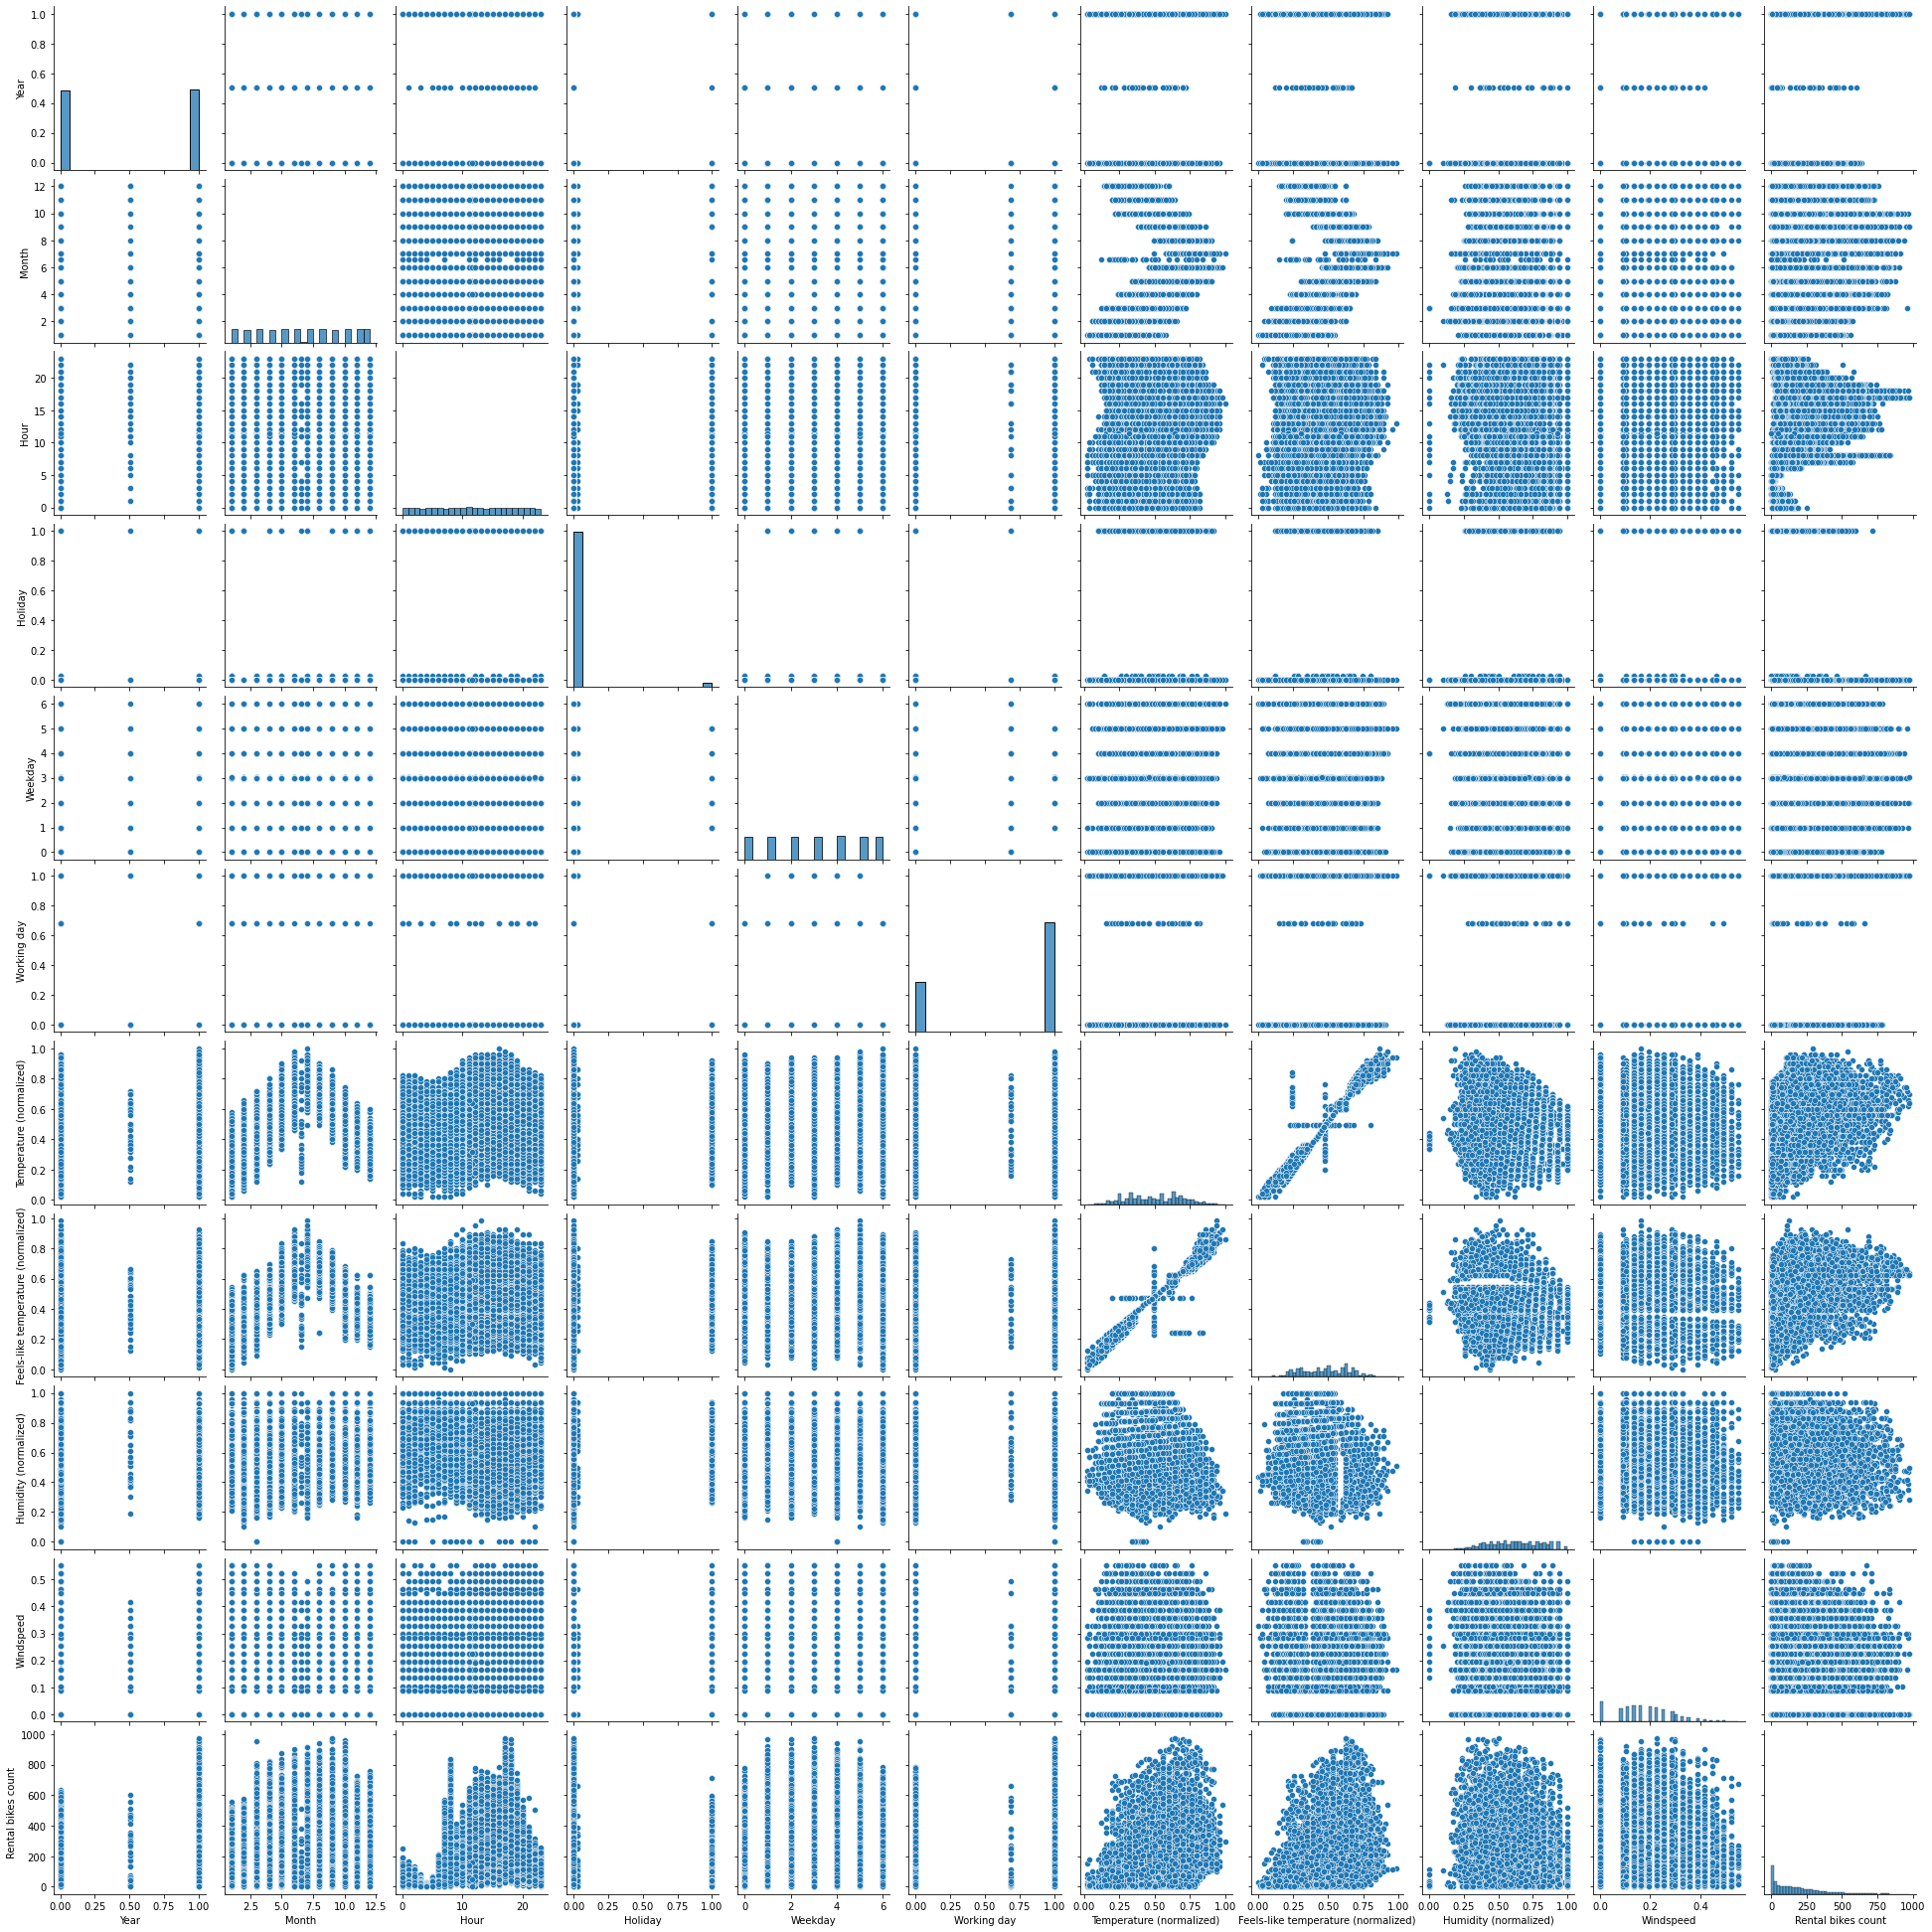

Pairplot of test data
: <seaborn.axisgrid.PairGrid object at 0x7fe918d3c9a0>


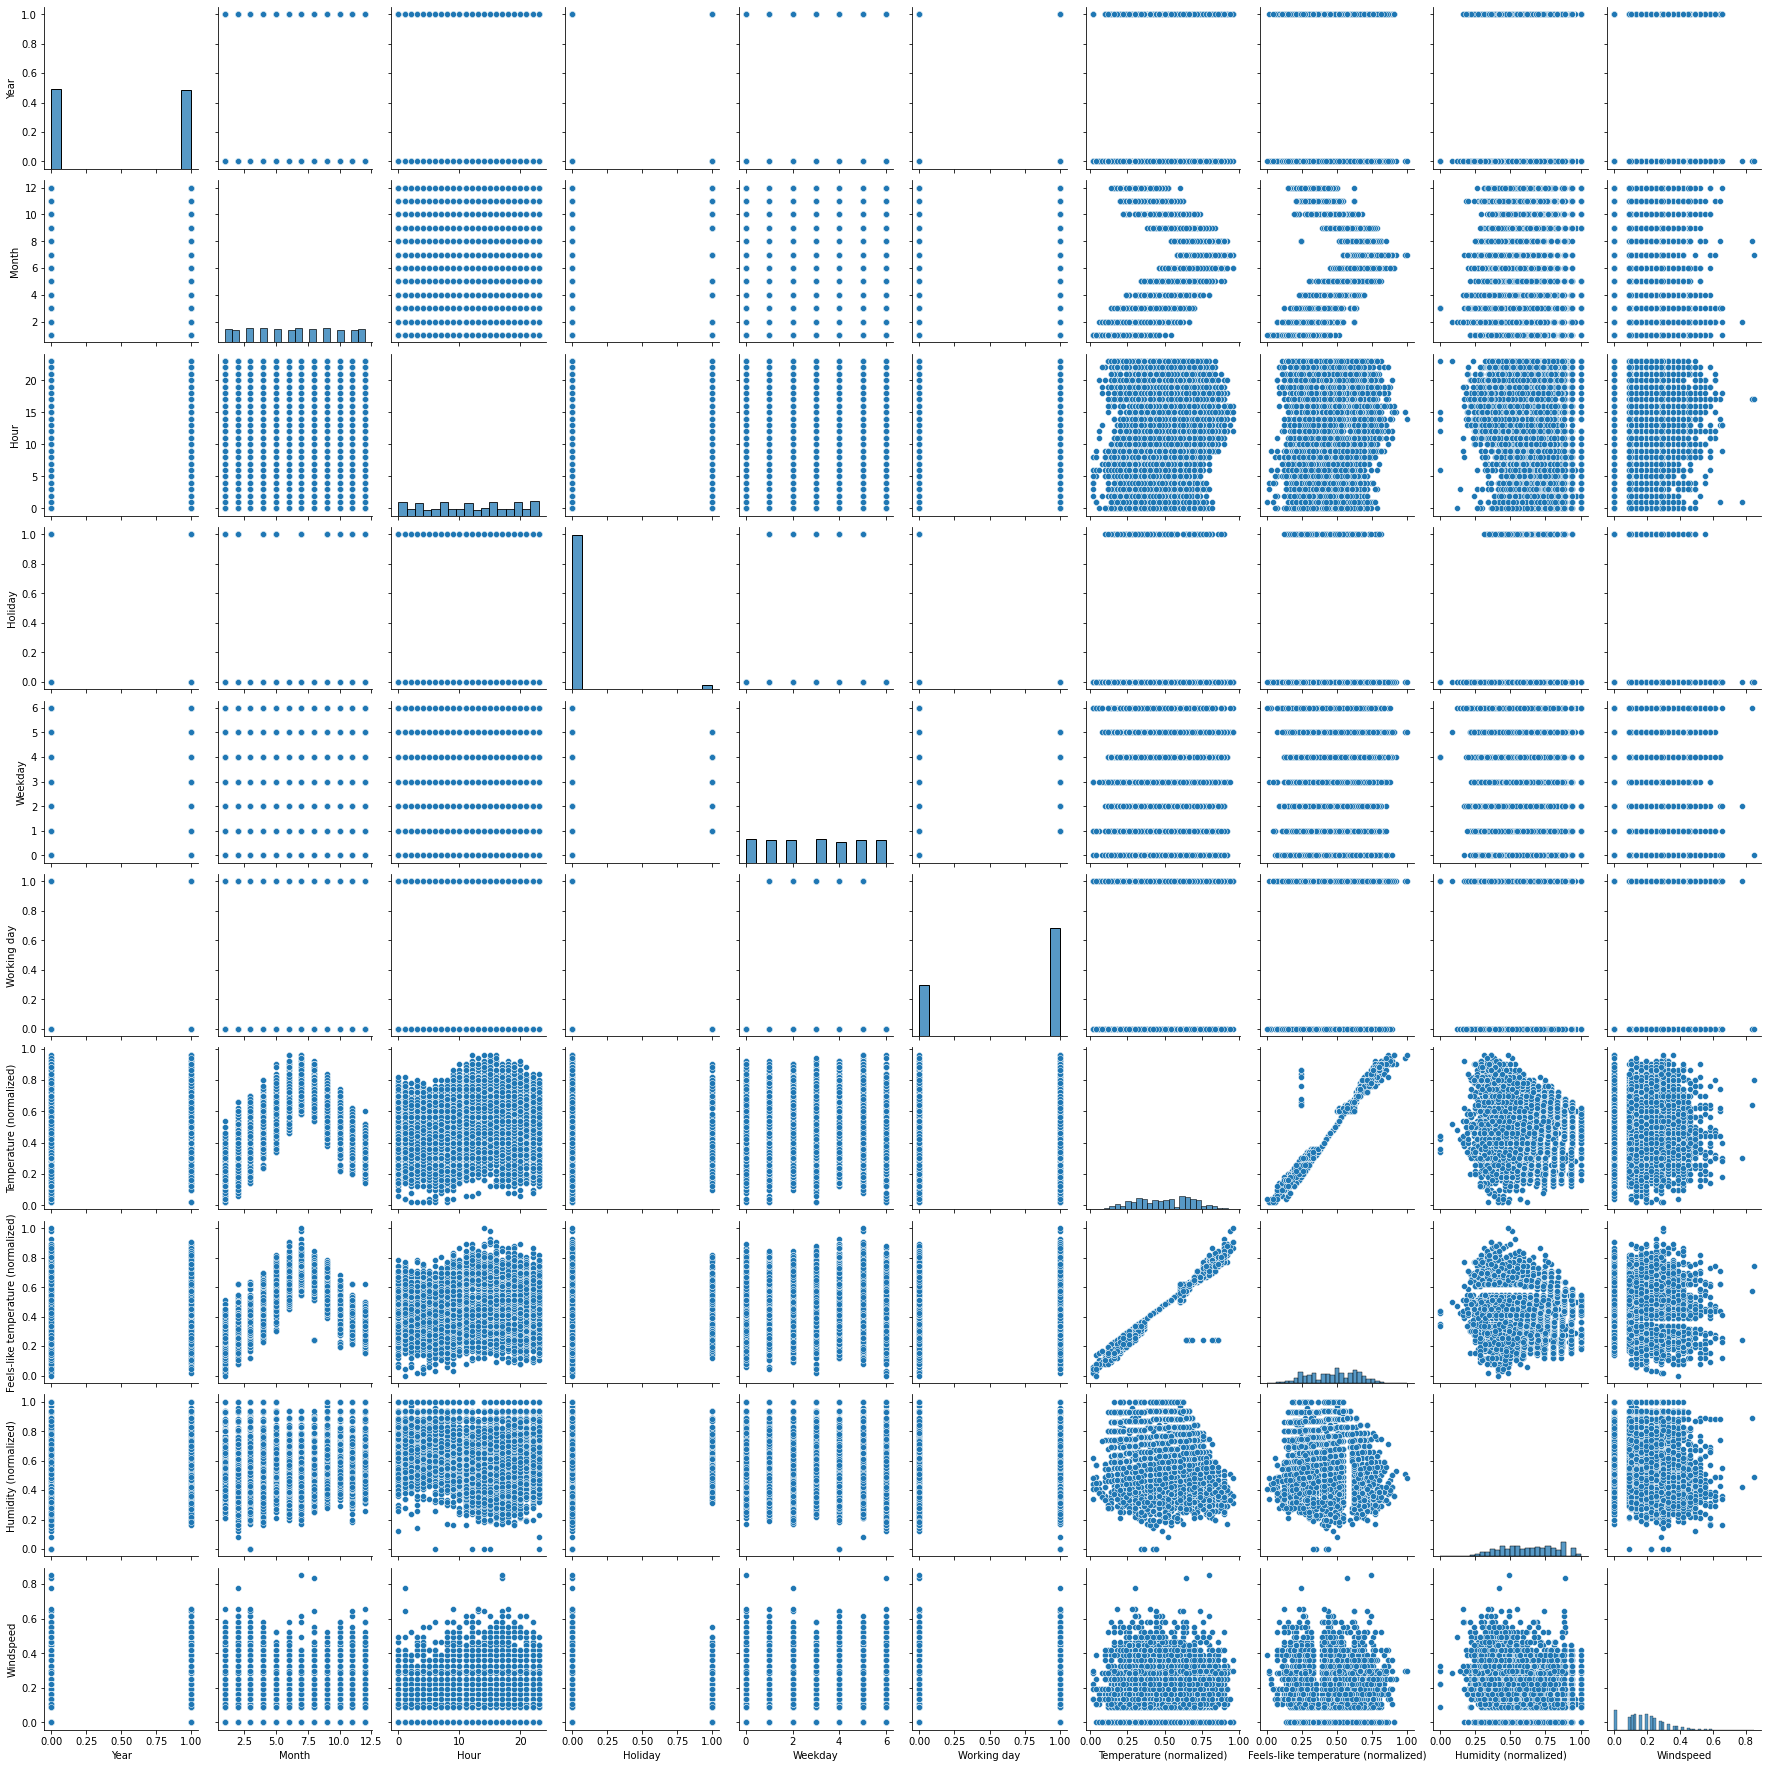

In [18]:
# Plot pairplot
print(f'Pairplot of train data\n: {sns.pairplot(df_train_clean)}')
plt.show()

print(f'Pairplot of test data\n: {sns.pairplot(raw_test)}')
plt.show()


Train data


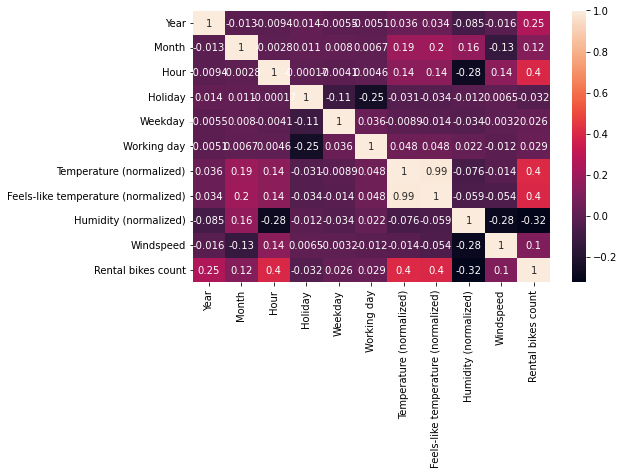

In [19]:
#Plot correlation matrix to see the correlation between the features
print('Train data')
plt.subplots(figsize=(8,5))
corr_train = sns.heatmap(df_train_clean.corr(), annot = True)
plt.show()


Test data


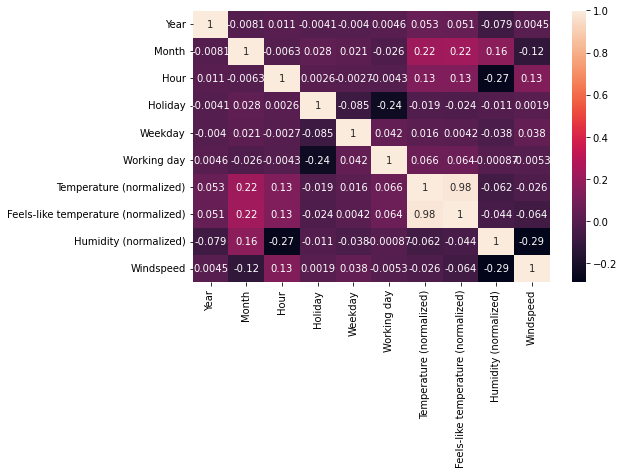

In [20]:
#Plot correlation matrix to see the correlation between the features
print('Test data')
plt.subplots(figsize=(8,5))
corr_train = sns.heatmap(raw_test.corr(), annot = True)
plt.show()

The features 'Feels- like temperature' and 'temperature' are highly correlated.

### Data preprocessing

In [64]:
# Leave out target before encoding
train_x_clean = df_train_clean.iloc[:,:-1]

# Drop the feature Temperature (normalized), beacuse of the high correlation with another feature
train_x_clean = train_x_clean.drop(labels='Temperature (normalized)', axis=1)

test_x = raw_test.copy() # make a copy of the raw test data, before removing the feature
test_x = test_x.drop(labels='Temperature (normalized)', axis=1)
test_x

,Season,Year,Month,Hour,Holiday,Weekday,Working day,Weather situation,Feels-like temperature (normalized),Humidity (normalized),Windspeed
0,Spring,1,6,19,0,5,1,Clear or partly cloudy,0.6364,0.42,0.1642
1,Summer,1,9,3,0,4,1,Clear or partly cloudy,0.4394,0.77,0.0000
2,Spring,0,4,14,0,1,1,Misty and/or cloudy,0.5455,0.49,0.1940
3,Spring,0,5,18,0,3,1,Clear or partly cloudy,0.6667,0.58,0.2239
4,Spring,0,4,3,0,3,1,Light snow or light rain,0.4091,0.94,0.3284
...,...,...,...,...,...,...,...,...,...,...,...
5209,Summer,0,7,20,0,1,1,Clear or partly cloudy,0.7424,0.59,0.2239
5210,Winter,0,2,22,0,6,0,Clear or partly cloudy,0.2576,0.28,0.4925
5211,Summer,0,9,22,0,0,0,Misty and/or cloudy,0.5152,0.68,0.0896
5212,Summer,1,8,0,0,3,1,Clear or partly cloudy,0.5758,0.83,0.1045


In [22]:
# Make copy of the data sets before encoding
x_train_ec = train_x_clean.copy()
x_test_ec = test_x.copy()

In [23]:
# Get the columns with categorical values for encoding
catogorical_col = [columns for columns in x_train_ec.select_dtypes(['object']).columns]
catogorical_col

['Season', 'Weather situation']

In [65]:
# Transform the columns with categorical data (Season, Weather) with one-hot encoding for train and test sets
x_train_ec = pd.get_dummies(x_train_ec, drop_first=True)
x_train_ec

,Year,Month,Hour,Holiday,Weekday,Working day,Feels-like temperature (normalized),Humidity (normalized),Windspeed,Season_Spring,Season_Summer,Season_Winter,"Weather situation_Heavy rain, heavy snow or thunderstorm",Weather situation_Light snow or light rain,Weather situation_Misty and/or cloudy
0,1.0,6.0,18.0,0.0,1.0,1.0,0.6667,0.27,0.4478,0,1,0,0,0,0
1,1.0,10.0,11.0,0.0,3.0,1.0,0.3485,0.66,0.2239,0,0,0,0,0,1
2,0.0,6.0,22.0,0.0,6.0,0.0,0.6212,0.57,0.2239,1,0,0,0,0,0
3,0.0,3.0,21.0,0.0,2.0,1.0,0.4242,0.54,0.2836,1,0,0,0,0,1
4,1.0,11.0,5.0,0.0,2.0,1.0,0.3333,0.66,0.1343,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12160,0.0,9.0,16.0,0.0,3.0,1.0,0.6970,0.52,0.2836,0,1,0,0,0,0
12161,0.0,5.0,8.0,0.0,1.0,1.0,0.5303,0.73,0.2985,1,0,0,0,0,0
12162,0.0,5.0,1.0,0.0,2.0,1.0,0.4545,0.59,0.0896,1,0,0,0,0,0
12163,0.0,4.0,16.0,0.0,2.0,1.0,0.4697,0.77,0.3881,1,0,0,0,0,1


In [66]:
# Do the same for test test
x_test_ec = pd.get_dummies(x_test_ec, drop_first=True)
x_test_ec

,Year,Month,Hour,Holiday,Weekday,Working day,Feels-like temperature (normalized),Humidity (normalized),Windspeed,Season_Spring,Season_Summer,Season_Winter,"Weather situation_Heavy rain, heavy snow or thunderstorm",Weather situation_Light snow or light rain,Weather situation_Misty and/or cloudy
0,1,6,19,0,5,1,0.6364,0.42,0.1642,1,0,0,0,0,0
1,1,9,3,0,4,1,0.4394,0.77,0.0000,0,1,0,0,0,0
2,0,4,14,0,1,1,0.5455,0.49,0.1940,1,0,0,0,0,1
3,0,5,18,0,3,1,0.6667,0.58,0.2239,1,0,0,0,0,0
4,0,4,3,0,3,1,0.4091,0.94,0.3284,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,0,7,20,0,1,1,0.7424,0.59,0.2239,0,1,0,0,0,0
5210,0,2,22,0,6,0,0.2576,0.28,0.4925,0,0,1,0,0,0
5211,0,9,22,0,0,0,0.5152,0.68,0.0896,0,1,0,0,0,1
5212,1,8,0,0,3,1,0.5758,0.83,0.1045,0,1,0,0,0,0


In [26]:
# Define original train data and test data for the final predictions
X_train_set = x_train_ec
y_train_set = df_train_clean['Rental bikes count']
X_test_set = x_test_ec

#### Train test split

In [67]:
# Split the train data set into train sets and test sets to use for training
X_train, X_test, y_train, y_test = train_test_split(
    X_train_set.values, y_train_set.values, test_size=0.3, random_state=1)

#### Scaling

In [28]:
# Scale the original train and test data

#Initialise standard scaler and compute mean and STD from training data
sc = StandardScaler()
sc.fit(X_train_set)
                
# Standardize both X_train and X_test with mean and STD from training data
X_train_set_sc = sc.transform(X_train_set)
X_test_set_sc = sc.transform(X_test_set)

### Modelling

#### Data pipeline with regression model

In [68]:
# Define the pipeline
pipe_forest = make_pipeline(RandomForestRegressor())

pipe_forest.fit(X_train, y_train)

pipe_forest.get_params()   # get the name of the parameters

{'memory': None,
 'steps': [('randomforestregressor', RandomForestRegressor())],
 'verbose': False,
 'randomforestregressor': RandomForestRegressor(),
 'randomforestregressor__bootstrap': True,
 'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__criterion': 'mse',
 'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__max_leaf_nodes': None,
 'randomforestregressor__max_samples': None,
 'randomforestregressor__min_impurity_decrease': 0.0,
 'randomforestregressor__min_impurity_split': None,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__min_weight_fraction_leaf': 0.0,
 'randomforestregressor__n_estimators': 100,
 'randomforestregressor__n_jobs': None,
 'randomforestregressor__oob_score': False,
 'randomforestregressor__random_state': None,
 'randomforestregressor__verbose': 0,
 'randomforestregressor__warm_start': False}

In [31]:
# Tuning the hyperparameter n_estimator with gridsearch
n_est = [*range(10,500,50)] # define the parameter range

param_grid_rf = [{'randomforestregressor__n_estimators': n_est}]

start = time.time()

gs_rf = GridSearchCV(estimator=pipe_forest, 
                  param_grid=param_grid_rf, 
                  scoring='r2', 
                  cv=10,
                  n_jobs=-1)

gs_rf = gs_rf.fit(X_train, y_train)

end = time.time()

print(f'Time used: {end - start}')
print(gs_rf.best_score_)
print(gs_rf.best_params_) # get the optimal parameter

Time used: 296.2833080291748
0.9344771357691822
{'randomforestregressor__n_estimators': 410}


#### Data pipeline with classification model

##### Binning train target values

Can be performed with ex. pandas.qcut or pandas.cut

```python
n_bins = 10
y_train_binned = pd.cut(y_train, n_bins, labels=False) # or
y_train_binned = pd.qcut(y_train, n_bins, labels=False) 
```

In [75]:
# Define the pipeline for Logistic regression Classifier to use for the prediction with binned target values:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(random_state=5, solver='liblinear', multi_class='auto', penalty='l2'))

In [76]:
n_bins = [10, 15, 20, 25, 30] # increasing the number of bins in order to see how it affect the performance
# Empty lists to store the train and test scores for the evaluation
train_score = []
test_score = []

def binned_target_modelling(x_train_data, y_train_data, clf):
    start = time.time()
    
    for n in n_bins:
        binned = pd.cut(y_train_set, n, labels=False)
        y_train_binned = pd.cut(y_train_data, n, labels=False)

        # Split the data into test and train sets
        X_train2, X_test2, y_train2, y_test2 = train_test_split(
                x_train_data.values, y_train_binned.values, test_size=0.3, random_state=1)
        
        clf.fit(X_train2, y_train2)
        
        # Define ranges of parameter values:
        par_c  = [0.01, 0.1, 1.0, 10.0, 100.0] 
        
        # Define the parameter grid for tuning
        param_grid_lr  = [{'logisticregression__C': par_c}]
        
        
        gs_lr = GridSearchCV(estimator=clf, 
                      param_grid=param_grid_lr, 
                      scoring='f1_macro', 
                      cv=4,
                      n_jobs=-1)
        gs_lr = gs_lr.fit(X_train2, y_train2)
       
        # predict on the test and train set with the optimal parameter
        y_train_pred = clf.predict(X_train2)
        y_prediction = clf.predict(X_test2)
        
        # compute the F1-macro score 
        f1_train = f1_score(y_true=y_train2, y_pred=y_train_pred, average='macro')
        f1_test = f1_score(y_true=y_test2, y_pred=y_prediction, average='macro')
        
        # Append the F1- scores to the lists with scores
        train_score.append(f1_train)
        test_score.append(f1_test)

        print(gs_lr.best_score_) 
        print(gs_lr.best_params_) 
        
    end = time.time()
    print(f'Time used: {end - start}')

In [77]:
# Use the function to convert the y targets to bins and tune the C parameter in the log. reg. clf.
res_1 = binned_target_modelling(X_train_set, y_train_set, pipe_lr)

0.15150321014818652
{'logisticregression__C': 10.0}
0.11116055602969531
{'logisticregression__C': 1.0}
0.09143601995559866
{'logisticregression__C': 1.0}
0.07255536761551765
{'logisticregression__C': 10.0}
0.06010025626900613
{'logisticregression__C': 100.0}
Time used: 53.13113617897034


### Final Evaluation

In [55]:
# Evaluating the performance of the regression model

y_train_pred_rf = pipe_forest.predict(X_train)
y_test_pred_rf = pipe_forest.predict(X_test)

print(f'Evaluation of Random forest regressor:\nOptimal parameter: {gs_rf.best_params_})')
print('MSE train : %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred_rf),
        mean_squared_error(y_test, y_test_pred_rf)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred_rf),
        r2_score(y_test, y_test_pred_rf)))


Evaluation of Random forest regressor:
Optimal parameter: {'randomforestregressor__n_estimators': 410})
MSE train : 295.856, test: 2095.122
R^2 train: 0.991, test: 0.938


In [78]:
# Evaluating the performance of the classification with binned targets

# Construct pandas dataframe from lists with f1_scores
f1_scores = {'train score':train_score, 'test score':test_score}
scores_df = pd.DataFrame(data=f1_scores)

# Add column showing the n_bins
scores_df['n_bins'] = ['{0}'.format(n) for n in n_bins]
scores_df

,train score,test score,n_bins
0,0.152932,0.146385,10
1,0.113051,0.108183,15
2,0.094687,0.089752,20
3,0.078219,0.068978,25
4,0.063256,0.059340,30


Increasing the number of bins seems to reduce the model performance on both train and test data.

### Kaggle submission

In [72]:
# Final prediction with the optimal parameter on the entire data
final_forest = RandomForestRegressor(n_estimators = 410) 

final_forest.fit(X_train_set, y_train_set)

final_forest_pred = final_forest.predict(X_test_set)

# This model gave this score on the kaggle leaderboard: 

In [73]:
# Create the submission file
rfr_pred_result = pd.DataFrame({'idx': raw_test.index.copy(),'Rental bikes count': final_forest_pred})
rfr_pred_result.set_index('idx')
submission_rfr = rfr_pred_result.to_csv('CA5_RandomForestRegressor_3_outlier_removed_drop_corrfeature.csv', index=False)